# EECS 453 Final Project
Author: Jason Ning

Disclaminer: Some code are taken from my EECS 351 project last year, they are mostly for loading the data

Data set: Intel Image Classification. Link: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/?select=seg_train

Note: The image sizes inside the data set are not consistent, though most are 150 * 150. This means resizing of images has to be done.

In [13]:
import os
from os import walk
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim

In [2]:
#Check the imports are working and GPU for torch
print(os.listdir("./"))
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only.")

['.ipynb_checkpoints', 'seg_pred', 'seg_test', 'seg_train', 'Train.ipynb']
PyTorch Version:  2.1.1
Torchvision Version:  0.16.1
Using the GPU!


### Data Mean & Median Calculation
The calculated mean and std will be used for normalization. Have to resize the data all to 150 * 150 since some images are not the same size

In [34]:
#resize and change it to Tensor
calc_transform = transforms.Compose([transforms.Resize((150, 150)),
                                     transforms.ToTensor()])
calc_dataset = datasets.ImageFolder("./seg_train/seg_train/",
                               transform=calc_transform)

calc_loader = torch.utils.data.DataLoader(calc_dataset, batch_size=32, 
                                          shuffle=False)

In [35]:
def get_mean_std(loader):
    chan_sum, chan_sq_sum, num_batch = 0, 0, 0
    for data, _ in tqdm(loader):
        chan_sum += torch.mean(data, dim=[0,2,3])
        chan_sq_sum += torch.mean(data**2, dim=[0,2,3])
        num_batch += 1
    mean = chan_sum/num_batch
    std = (chan_sq_sum/num_batch - mean**2) ** 0.5
    return mean, std

mean, std = get_mean_std(calc_loader)
print('mean: '  + str(mean))
print('std:  '  + str(std))

100%|██████████| 439/439 [00:07<00:00, 61.76it/s]

mean: tensor([0.4302, 0.4575, 0.4538])
std:  tensor([0.2699, 0.2681, 0.2985])


## Data Normalization & Resizing 

In [72]:
# mean: tensor([0.4302, 0.4575, 0.4538])
# std:  tensor([0.2699, 0.2681, 0.2985])
transform = transforms.Compose([transforms.Resize((150, 150)),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.4302, 0.4575, 0.4538], 
                                                     [0.2699, 0.2681, 0.2985])])
dataset = datasets.ImageFolder("./seg_train/seg_train/",
                               transform=transform)

#shuffle is false for showing the images
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                          shuffle=False)

In [56]:
labels_map = {
    0: "buildings",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street",
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


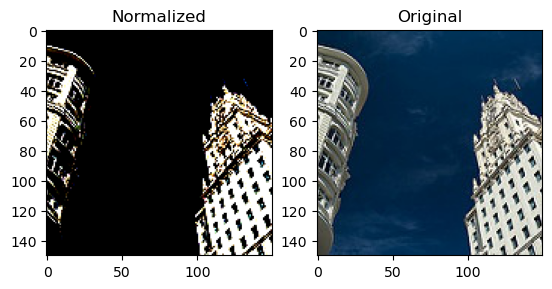

In [77]:
# Get one batch
images, labels = next(iter(data_loader))
images1, labels1 = next(iter(calc_loader))

# see some pictures
some_index = 4

fig, axs = plt.subplots(1,2)
plt.title(labels_map[labels[some_index].item()])
axs[0].set_title('Normalized')
axs[1].set_title('Original')
axs[0].imshow(images[some_index].permute(1,2,0))
axs[1].imshow(images1[some_index].permute(1,2,0))

In [78]:
#Change Shuffle to true for training
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, 
                                          shuffle=True)


## The Model 

In [79]:
# implementation of VGG-BN for 3*256*256 inputs
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True))
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True))
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))
        
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True))
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)
        
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv9 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv10 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        self.conv11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv12 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.conv13 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True))
        
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation = 1, ceil_mode=False)

        
        self.adaptive = nn.AdaptiveAvgPool2d(output_size=(7,7))
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=25088, out_features = 4096, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features = 4096, bias = True),
            nn.ReLU(inplace = True),
            nn.Dropout(p=0.3, inplace = False))
        
        self.fc3 = nn.Linear(in_features=4096, out_features = 6, bias = True)
        
    def forward(self, x):
        x = self.conv1(x) 
        x = self.conv2(x) 
        x = self.pool1(x) 
        x = self.conv3(x) 
        x = self.conv4(x) 
        x = self.pool2(x) 
        x = self.conv5(x) 
        x = self.conv6(x)   
        x = self.conv7(x)  
        x = self.pool3(x) 
        x = self.conv8(x) 
        x = self.conv9(x) 
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.pool5(x)
        x = self.adaptive(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_s

In [80]:
summary(net, input_size = (32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 64, 256, 256]        1,792
│    └─BatchNorm2d: 2-2                  [32, 64, 256, 256]        128
│    └─ReLU: 2-3                         [32, 64, 256, 256]        --
├─Sequential: 1-2                        [32, 64, 256, 256]        --
│    └─Conv2d: 2-4                       [32, 64, 256, 256]        36,928
│    └─BatchNorm2d: 2-5                  [32, 64, 256, 256]        128
│    └─ReLU: 2-6                         [32, 64, 256, 256]        --
├─MaxPool2d: 1-3                         [32, 64, 128, 128]        --
├─Sequential: 1-4                        [32, 128, 128, 128]       --
│    └─Conv2d: 2-7                       [32, 128, 128, 128]       73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 128, 128]       256
│

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# training
num_epoch = 3
total_step = len(data_loader)
stats = np.empty((0,3), float)

for epoch in tqdm(range(num_epoch)):  # loop over the dataset multiple times
    running_loss = 0.0
    running_correct = 0
    print('------ Starting Epoch [{}/{}] ------'.format(epoch+1, num_epoch))
    for i, data in tqdm(enumerate(data_loader, 0)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        
        # back prop
        loss.backward()
        optimizer.step()

#         # stats
#         running_loss += loss.item()*inputs.size(0)
#         running_correct += torch.sum(preds == labels)
#         stats = np.vstack((stats, np.array([running_loss, running_correct, (i+1)*32])))
        
        if(i % 20  == 1):
            print('Epoch [{}/{}], Step [{}/{}], Running Loss: {:.4f}, running Correct: [{}/{}]'
              .format(epoch+1, num_epoch, i+1, total_step, running_loss, running_correct, (i+1)*32))
    
#     #save trained model every 5 epochs
#     if(epoch % 5 == 4):
#         PATH = './epoch_{}.pth'.format(epoch+1)
#         torch.save(net.state_dict(), PATH)
        
print('Finished Training')

  0%|          | 0/3 [00:00<?, ?it/s]

------ Starting Epoch [1/3] ------



0it [00:00, ?it/s]
2it [00:00,  5.39it/s]
3it [00:00,  6.40it/s]

Epoch [1/3], Step [2/439], Running Loss: 0.0000, running Correct: [0/64]



4it [00:00,  7.18it/s]
5it [00:00,  7.70it/s]
6it [00:00,  8.09it/s]
7it [00:00,  8.34it/s]
8it [00:01,  8.54it/s]
9it [00:01,  8.64it/s]
10it [00:01,  8.72it/s]
11it [00:01,  8.78it/s]
12it [00:01,  8.85it/s]
13it [00:01,  8.90it/s]
14it [00:01,  8.91it/s]
15it [00:01,  8.96it/s]
16it [00:01,  9.00it/s]
17it [00:02,  9.05it/s]
18it [00:02,  9.11it/s]
19it [00:02,  9.05it/s]
20it [00:02,  8.99it/s]
21it [00:02,  8.99it/s]
22it [00:02,  8.97it/s]
23it [00:02,  8.98it/s]

Epoch [1/3], Step [22/439], Running Loss: 0.0000, running Correct: [0/704]



24it [00:02,  8.99it/s]
25it [00:02,  8.97it/s]
26it [00:03,  8.98it/s]
27it [00:03,  8.99it/s]
28it [00:03,  8.97it/s]
29it [00:03,  8.98it/s]
30it [00:03,  8.91it/s]
31it [00:03,  8.94it/s]
32it [00:03,  8.96it/s]
33it [00:03,  8.93it/s]
34it [00:03,  8.95it/s]
35it [00:04,  8.92it/s]
36it [00:04,  8.97it/s]
37it [00:04,  9.01it/s]
38it [00:04,  9.01it/s]
39it [00:04,  9.01it/s]
40it [00:04,  9.01it/s]
41it [00:04,  8.98it/s]
42it [00:04,  8.99it/s]
43it [00:04,  8.97it/s]

Epoch [1/3], Step [42/439], Running Loss: 0.0000, running Correct: [0/1344]



44it [00:05,  8.98it/s]
45it [00:05,  8.97it/s]
46it [00:05,  8.97it/s]
47it [00:05,  8.96it/s]
48it [00:05,  8.90it/s]
49it [00:05,  8.91it/s]
50it [00:05,  8.94it/s]
51it [00:05,  8.96it/s]
52it [00:05,  9.00it/s]
53it [00:06,  9.07it/s]
54it [00:06,  9.10it/s]
55it [00:06,  9.05it/s]
56it [00:06,  9.04it/s]
57it [00:06,  9.03it/s]
58it [00:06,  9.00it/s]
59it [00:06,  9.02it/s]
60it [00:06,  9.00it/s]
61it [00:06,  9.00it/s]
62it [00:07,  8.98it/s]
63it [00:07,  8.94it/s]

Epoch [1/3], Step [62/439], Running Loss: 0.0000, running Correct: [0/1984]



64it [00:07,  8.94it/s]
65it [00:07,  8.96it/s]
66it [00:07,  8.95it/s]
67it [00:07,  8.96it/s]
68it [00:07,  8.98it/s]
69it [00:07,  8.96it/s]
70it [00:07,  9.03it/s]
71it [00:08,  9.09it/s]
72it [00:08,  9.09it/s]
73it [00:08,  9.09it/s]
74it [00:08,  9.06it/s]
75it [00:08,  9.00it/s]
76it [00:08,  8.98it/s]
77it [00:08,  8.98it/s]
78it [00:08,  8.99it/s]
79it [00:08,  8.97it/s]
80it [00:09,  8.98it/s]
81it [00:09,  8.99it/s]
82it [00:09,  9.00it/s]
83it [00:09,  8.97it/s]

Epoch [1/3], Step [82/439], Running Loss: 0.0000, running Correct: [0/2624]



84it [00:09,  8.98it/s]
85it [00:09,  8.99it/s]
86it [00:09,  8.99it/s]
87it [00:09,  8.97it/s]
88it [00:09,  9.01it/s]
89it [00:10,  9.08it/s]
90it [00:10,  9.06it/s]
91it [00:10,  9.02it/s]
92it [00:10,  8.97it/s]
93it [00:10,  8.98it/s]
94it [00:10,  8.99it/s]
95it [00:10,  9.02it/s]
96it [00:10,  9.01it/s]
97it [00:10,  9.01it/s]
98it [00:11,  8.98it/s]
99it [00:11,  9.02it/s]
100it [00:11,  8.99it/s]
101it [00:11,  9.00it/s]
102it [00:11,  8.98it/s]
103it [00:11,  8.95it/s]

Epoch [1/3], Step [102/439], Running Loss: 0.0000, running Correct: [0/3264]



104it [00:11,  8.97it/s]
105it [00:11,  8.93it/s]
106it [00:11,  8.98it/s]
107it [00:12,  9.04it/s]
108it [00:12,  9.08it/s]
109it [00:12,  9.03it/s]
110it [00:12,  9.00it/s]
111it [00:12,  9.00it/s]
112it [00:12,  8.96it/s]
113it [00:12,  8.97it/s]
114it [00:12,  8.96it/s]
115it [00:12,  8.95it/s]
116it [00:13,  8.94it/s]
117it [00:13,  8.96it/s]
118it [00:13,  9.00it/s]
119it [00:13,  8.98it/s]
120it [00:13,  8.99it/s]
121it [00:13,  9.01it/s]
122it [00:13,  8.99it/s]
123it [00:13,  8.95it/s]

Epoch [1/3], Step [122/439], Running Loss: 0.0000, running Correct: [0/3904]



124it [00:13,  8.96it/s]
125it [00:14,  9.00it/s]
126it [00:14,  9.08it/s]
127it [00:14,  9.06it/s]
128it [00:14,  9.04it/s]
129it [00:14,  9.08it/s]
130it [00:14,  9.03it/s]
131it [00:14,  9.00it/s]
132it [00:14,  9.05it/s]
133it [00:14,  9.01it/s]
134it [00:15,  8.99it/s]
135it [00:15,  9.02it/s]
136it [00:15,  9.02it/s]
137it [00:15,  9.01it/s]
138it [00:15,  9.04it/s]
139it [00:15,  9.03it/s]
140it [00:15,  9.02it/s]
141it [00:15,  9.02it/s]
142it [00:15,  9.09it/s]
143it [00:16,  9.09it/s]

Epoch [1/3], Step [142/439], Running Loss: 0.0000, running Correct: [0/4544]



144it [00:16,  9.14it/s]
145it [00:16,  9.10it/s]
146it [00:16,  9.07it/s]
147it [00:16,  9.05it/s]
148it [00:16,  9.01it/s]
149it [00:16,  9.01it/s]
150it [00:16,  9.01it/s]
151it [00:16,  9.03it/s]
152it [00:17,  9.02it/s]
153it [00:17,  9.02it/s]
154it [00:17,  9.02it/s]
155it [00:17,  9.01it/s]
156it [00:17,  9.01it/s]
157it [00:17,  9.01it/s]
158it [00:17,  9.01it/s]
159it [00:17,  9.01it/s]
160it [00:17,  9.05it/s]
161it [00:18,  9.09it/s]
162it [00:18,  9.11it/s]
163it [00:18,  9.08it/s]

Epoch [1/3], Step [162/439], Running Loss: 0.0000, running Correct: [0/5184]



164it [00:18,  9.06it/s]
165it [00:18,  9.04it/s]
166it [00:18,  9.03it/s]
167it [00:18,  9.05it/s]
168it [00:18,  9.01it/s]
169it [00:18,  9.03it/s]
170it [00:19,  9.03it/s]
171it [00:19,  8.99it/s]
172it [00:19,  9.02it/s]
173it [00:19,  8.99it/s]
174it [00:19,  9.00it/s]
175it [00:19,  9.03it/s]
176it [00:19,  8.99it/s]
177it [00:19,  9.00it/s]
178it [00:19,  9.05it/s]
179it [00:20,  9.09it/s]
180it [00:20,  9.11it/s]
181it [00:20,  9.08it/s]
182it [00:20,  9.06it/s]
183it [00:20,  9.07it/s]

Epoch [1/3], Step [182/439], Running Loss: 0.0000, running Correct: [0/5824]



184it [00:20,  9.05it/s]
185it [00:20,  9.03it/s]
186it [00:20,  9.00it/s]
187it [00:20,  9.03it/s]
188it [00:21,  9.02it/s]
189it [00:21,  8.99it/s]
190it [00:21,  9.02it/s]
191it [00:21,  8.99it/s]
192it [00:21,  9.00it/s]
193it [00:21,  9.00it/s]
194it [00:21,  9.00it/s]
195it [00:21,  9.00it/s]
196it [00:21,  9.03it/s]
197it [00:22,  9.05it/s]
198it [00:22,  9.11it/s]
199it [00:22,  9.10it/s]
200it [00:22,  9.05it/s]
201it [00:22,  9.06it/s]
202it [00:22,  9.02it/s]
203it [00:22,  9.02it/s]

Epoch [1/3], Step [202/439], Running Loss: 0.0000, running Correct: [0/6464]



204it [00:22,  9.01it/s]
205it [00:22,  9.01it/s]
206it [00:23,  9.01it/s]
207it [00:23,  9.03it/s]
208it [00:23,  9.03it/s]
209it [00:23,  9.02it/s]
210it [00:23,  9.02it/s]
211it [00:23,  9.02it/s]
212it [00:23,  9.01it/s]
213it [00:23,  9.01it/s]
214it [00:23,  9.03it/s]
215it [00:24,  9.08it/s]
216it [00:24,  9.10it/s]
217it [00:24,  9.10it/s]
218it [00:24,  9.07it/s]
219it [00:24,  9.08it/s]
220it [00:24,  9.05it/s]
221it [00:24,  9.04it/s]
222it [00:24,  9.03it/s]
223it [00:24,  9.02it/s]

Epoch [1/3], Step [222/439], Running Loss: 0.0000, running Correct: [0/7104]



224it [00:25,  9.02it/s]
225it [00:25,  9.01it/s]
226it [00:25,  8.99it/s]
227it [00:25,  8.99it/s]
228it [00:25,  9.00it/s]
229it [00:25,  8.97it/s]
230it [00:25,  8.98it/s]
231it [00:25,  9.01it/s]
232it [00:25,  9.01it/s]
233it [00:26,  9.06it/s]
234it [00:26,  9.09it/s]
235it [00:26,  9.12it/s]
236it [00:26,  9.06it/s]
237it [00:26,  9.04it/s]
238it [00:26,  9.06it/s]
239it [00:26,  9.02it/s]
240it [00:26,  9.04it/s]
241it [00:26,  9.00it/s]
242it [00:27,  9.01it/s]
243it [00:27,  9.01it/s]

Epoch [1/3], Step [242/439], Running Loss: 0.0000, running Correct: [0/7744]



244it [00:27,  9.01it/s]
245it [00:27,  8.98it/s]
246it [00:27,  9.02it/s]
247it [00:27,  9.01it/s]
248it [00:27,  8.99it/s]
249it [00:27,  9.02it/s]
250it [00:27,  9.01it/s]
251it [00:28,  9.09it/s]
252it [00:28,  9.11it/s]
253it [00:28,  9.11it/s]
254it [00:28,  9.10it/s]
255it [00:28,  9.05it/s]
256it [00:28,  9.01it/s]
257it [00:28,  9.01it/s]
258it [00:28,  9.03it/s]
259it [00:28,  9.02it/s]
260it [00:29,  8.99it/s]
261it [00:29,  9.00it/s]
262it [00:29,  9.02it/s]
263it [00:29,  8.97it/s]

Epoch [1/3], Step [262/439], Running Loss: 0.0000, running Correct: [0/8384]



264it [00:29,  9.01it/s]
265it [00:29,  8.98it/s]
266it [00:29,  9.01it/s]
267it [00:29,  9.01it/s]
268it [00:29,  9.01it/s]
269it [00:29,  9.08it/s]
270it [00:30,  9.08it/s]
271it [00:30,  9.11it/s]
272it [00:30,  9.08it/s]
273it [00:30,  9.08it/s]
274it [00:30,  9.06it/s]
275it [00:30,  9.04it/s]
276it [00:30,  9.03it/s]
277it [00:30,  9.02it/s]
278it [00:30,  9.02it/s]
279it [00:31,  9.01it/s]
280it [00:31,  8.99it/s]
281it [00:31,  8.99it/s]
282it [00:31,  9.02it/s]
283it [00:31,  9.02it/s]

Epoch [1/3], Step [282/439], Running Loss: 0.0000, running Correct: [0/9024]



284it [00:31,  8.99it/s]
285it [00:31,  9.02it/s]
286it [00:31,  9.04it/s]
287it [00:31,  9.08it/s]
288it [00:32,  9.13it/s]
289it [00:32,  9.12it/s]
290it [00:32,  9.11it/s]
291it [00:32,  9.06it/s]
292it [00:32,  9.04it/s]
293it [00:32,  9.05it/s]
294it [00:32,  9.04it/s]
295it [00:32,  9.01it/s]
296it [00:32,  9.00it/s]
297it [00:33,  8.98it/s]
298it [00:33,  9.01it/s]
299it [00:33,  9.01it/s]
300it [00:33,  9.01it/s]
301it [00:33,  9.03it/s]
302it [00:33,  9.02it/s]
303it [00:33,  8.99it/s]

Epoch [1/3], Step [302/439], Running Loss: 0.0000, running Correct: [0/9664]



304it [00:33,  9.02it/s]
305it [00:33,  9.07it/s]
306it [00:34,  9.12it/s]
307it [00:34,  9.11it/s]
308it [00:34,  9.08it/s]
309it [00:34,  9.06it/s]
310it [00:34,  9.04it/s]
311it [00:34,  9.03it/s]
312it [00:34,  9.00it/s]
313it [00:34,  9.03it/s]
314it [00:34,  9.02it/s]
315it [00:35,  9.04it/s]
316it [00:35,  9.01it/s]
317it [00:35,  9.03it/s]
318it [00:35,  9.03it/s]
319it [00:35,  9.02it/s]
320it [00:35,  8.99it/s]
321it [00:35,  8.99it/s]
322it [00:35,  9.00it/s]
323it [00:35,  9.07it/s]

Epoch [1/3], Step [322/439], Running Loss: 0.0000, running Correct: [0/10304]



324it [00:36,  9.08it/s]
325it [00:36,  9.11it/s]
326it [00:36,  9.08it/s]
327it [00:36,  9.06it/s]
328it [00:36,  9.04it/s]
329it [00:36,  9.01it/s]
330it [00:36,  9.03it/s]
331it [00:36,  9.00it/s]
332it [00:36,  9.03it/s]
333it [00:37,  9.02it/s]
334it [00:37,  8.99it/s]
335it [00:37,  9.01it/s]
336it [00:37,  9.01it/s]
337it [00:37,  9.01it/s]
338it [00:37,  8.99it/s]
339it [00:37,  8.99it/s]
340it [00:37,  9.02it/s]
341it [00:37,  9.04it/s]
342it [00:38,  9.10it/s]
343it [00:38,  9.12it/s]

Epoch [1/3], Step [342/439], Running Loss: 0.0000, running Correct: [0/10944]



344it [00:38,  9.11it/s]
345it [00:38,  9.06it/s]
346it [00:38,  9.04it/s]
347it [00:38,  9.06it/s]
348it [00:38,  9.02it/s]
349it [00:38,  8.99it/s]
350it [00:38,  8.99it/s]
351it [00:39,  9.02it/s]
352it [00:39,  9.02it/s]
353it [00:39,  9.04it/s]
354it [00:39,  9.03it/s]
355it [00:39,  9.02it/s]
356it [00:39,  9.02it/s]
357it [00:39,  9.01it/s]
358it [00:39,  8.99it/s]
359it [00:39,  9.04it/s]
360it [00:40,  9.10it/s]
361it [00:40,  9.15it/s]
362it [00:40,  9.11it/s]
363it [00:40,  9.08it/s]

Epoch [1/3], Step [362/439], Running Loss: 0.0000, running Correct: [0/11584]



364it [00:40,  9.06it/s]
365it [00:40,  9.04it/s]
366it [00:40,  9.03it/s]
367it [00:40,  9.02it/s]
368it [00:40,  9.04it/s]
369it [00:41,  9.01it/s]
370it [00:41,  9.01it/s]
371it [00:41,  9.01it/s]
372it [00:41,  8.98it/s]
373it [00:41,  8.99it/s]
374it [00:41,  9.00it/s]
375it [00:41,  9.00it/s]
376it [00:41,  9.00it/s]
377it [00:41,  9.05it/s]
378it [00:42,  9.11it/s]
379it [00:42,  9.13it/s]
380it [00:42,  9.12it/s]
381it [00:42,  9.08it/s]
382it [00:42,  9.04it/s]
383it [00:42,  9.03it/s]

Epoch [1/3], Step [382/439], Running Loss: 0.0000, running Correct: [0/12224]



384it [00:42,  9.05it/s]
385it [00:42,  9.01it/s]
386it [00:42,  9.01it/s]
387it [00:43,  9.01it/s]
388it [00:43,  9.01it/s]
389it [00:43,  9.01it/s]
390it [00:43,  9.03it/s]
391it [00:43,  9.03it/s]
392it [00:43,  9.00it/s]
393it [00:43,  9.02it/s]
394it [00:43,  9.02it/s]
395it [00:43,  9.06it/s]
396it [00:44,  9.07it/s]
397it [00:44,  9.12it/s]
398it [00:44,  9.09it/s]
399it [00:44,  9.06it/s]
400it [00:44,  9.05it/s]
401it [00:44,  9.04it/s]
402it [00:44,  9.03it/s]
403it [00:44,  9.02it/s]

Epoch [1/3], Step [402/439], Running Loss: 0.0000, running Correct: [0/12864]



404it [00:44,  8.99it/s]
405it [00:45,  9.00it/s]
406it [00:45,  9.02it/s]
407it [00:45,  8.99it/s]
408it [00:45,  9.00it/s]
409it [00:45,  9.00it/s]
410it [00:45,  9.00it/s]
411it [00:45,  9.01it/s]
412it [00:45,  8.98it/s]
413it [00:45,  9.04it/s]
414it [00:46,  9.08it/s]
415it [00:46,  9.10it/s]
416it [00:46,  9.10it/s]
417it [00:46,  9.07it/s]
418it [00:46,  9.03it/s]
419it [00:46,  9.05it/s]
420it [00:46,  9.01it/s]
421it [00:46,  9.01it/s]
422it [00:46,  9.01it/s]
423it [00:47,  9.01it/s]

Epoch [1/3], Step [422/439], Running Loss: 0.0000, running Correct: [0/13504]



424it [00:47,  8.98it/s]
425it [00:47,  9.01it/s]
426it [00:47,  9.01it/s]
427it [00:47,  9.01it/s]
428it [00:47,  9.04it/s]
429it [00:47,  9.00it/s]
430it [00:47,  9.00it/s]
431it [00:47,  9.03it/s]
432it [00:48,  9.07it/s]
433it [00:48,  9.10it/s]
434it [00:48,  9.12it/s]
435it [00:48,  9.06it/s]
436it [00:48,  9.02it/s]
437it [00:48,  9.02it/s]
438it [00:48,  9.02it/s]
439it [00:48,  8.99it/s]
 33%|███▎      | 1/3 [00:48<01:37, 48.84s/it]

------ Starting Epoch [2/3] ------



0it [00:00, ?it/s]
2it [00:00, 13.51it/s]

Epoch [2/3], Step [2/439], Running Loss: 0.0000, running Correct: [0/64]



4it [00:00, 10.47it/s]
6it [00:00,  9.71it/s]
7it [00:00,  9.52it/s]
8it [00:00,  9.38it/s]
9it [00:00,  9.28it/s]
10it [00:01,  9.20it/s]
11it [00:01,  9.22it/s]
12it [00:01,  9.23it/s]
13it [00:01,  9.19it/s]
14it [00:01,  9.16it/s]
15it [00:01,  9.11it/s]
16it [00:01,  9.08it/s]
17it [00:01,  9.04it/s]
18it [00:01,  9.05it/s]
19it [00:02,  9.04it/s]
20it [00:02,  9.03it/s]
21it [00:02,  9.02it/s]
22it [00:02,  9.02it/s]
23it [00:02,  8.99it/s]

Epoch [2/3], Step [22/439], Running Loss: 0.0000, running Correct: [0/704]



24it [00:02,  9.02it/s]
25it [00:02,  8.99it/s]
26it [00:02,  9.00it/s]
27it [00:02,  9.00it/s]
28it [00:03,  9.00it/s]
29it [00:03,  9.03it/s]
30it [00:03,  9.12it/s]
31it [00:03,  9.11it/s]
32it [00:03,  9.05it/s]
33it [00:03,  9.06it/s]
34it [00:03,  9.02it/s]
35it [00:03,  8.99it/s]
36it [00:03,  9.00it/s]
37it [00:04,  9.00it/s]
38it [00:04,  9.00it/s]
39it [00:04,  8.98it/s]
40it [00:04,  8.99it/s]
41it [00:04,  8.99it/s]
42it [00:04,  8.97it/s]
43it [00:04,  8.98it/s]

Epoch [2/3], Step [42/439], Running Loss: 0.0000, running Correct: [0/1344]



44it [00:04,  8.97it/s]
45it [00:04,  8.98it/s]
46it [00:05,  8.99it/s]
47it [00:05,  9.06it/s]
48it [00:05,  9.10it/s]
49it [00:05,  9.12it/s]
50it [00:05,  9.06it/s]
51it [00:05,  9.02it/s]
52it [00:05,  9.02it/s]
53it [00:05,  9.01it/s]
54it [00:05,  9.01it/s]
55it [00:06,  8.99it/s]
56it [00:06,  8.99it/s]
57it [00:06,  9.00it/s]
58it [00:06,  9.00it/s]
59it [00:06,  9.00it/s]
60it [00:06,  9.00it/s]
61it [00:06,  8.98it/s]
62it [00:06,  8.99it/s]
63it [00:06,  8.99it/s]

Epoch [2/3], Step [62/439], Running Loss: 0.0000, running Correct: [0/1984]



64it [00:07,  9.00it/s]
65it [00:07,  9.05it/s]
66it [00:07,  9.11it/s]
67it [00:07,  9.10it/s]
68it [00:07,  9.08it/s]
69it [00:07,  9.06it/s]
70it [00:07,  9.02it/s]
71it [00:07,  9.01it/s]
72it [00:07,  8.99it/s]
73it [00:08,  8.99it/s]
74it [00:08,  9.00it/s]
75it [00:08,  9.00it/s]
76it [00:08,  9.00it/s]
77it [00:08,  9.00it/s]
78it [00:08,  9.00it/s]
79it [00:08,  8.98it/s]
80it [00:08,  8.99it/s]
81it [00:08,  8.97it/s]
82it [00:09,  9.01it/s]
83it [00:09,  9.03it/s]

Epoch [2/3], Step [82/439], Running Loss: 0.0000, running Correct: [0/2624]



84it [00:09,  9.07it/s]
85it [00:09,  9.13it/s]
86it [00:09,  9.09it/s]
87it [00:09,  9.06it/s]
88it [00:09,  9.02it/s]
89it [00:09,  9.02it/s]
90it [00:09,  8.99it/s]
91it [00:10,  9.00it/s]
92it [00:10,  9.00it/s]
93it [00:10,  8.98it/s]
94it [00:10,  8.99it/s]
95it [00:10,  8.99it/s]
96it [00:10,  8.97it/s]
97it [00:10,  9.01it/s]
98it [00:10,  8.98it/s]
99it [00:10,  8.97it/s]
100it [00:11,  8.98it/s]
101it [00:11,  9.03it/s]
102it [00:11,  9.08it/s]
103it [00:11,  9.11it/s]

Epoch [2/3], Step [102/439], Running Loss: 0.0000, running Correct: [0/3264]



104it [00:11,  9.08it/s]
105it [00:11,  9.03it/s]
106it [00:11,  9.02it/s]
107it [00:11,  9.02it/s]
108it [00:11,  8.97it/s]
109it [00:12,  9.00it/s]
110it [00:12,  8.98it/s]
111it [00:12,  8.99it/s]
112it [00:12,  8.99it/s]
113it [00:12,  9.00it/s]
114it [00:12,  9.00it/s]
115it [00:12,  8.98it/s]
116it [00:12,  8.96it/s]
117it [00:12,  8.95it/s]
118it [00:13,  8.97it/s]
119it [00:13,  9.03it/s]
120it [00:13,  9.10it/s]
121it [00:13,  9.12it/s]
122it [00:13,  9.04it/s]
123it [00:13,  9.05it/s]

Epoch [2/3], Step [122/439], Running Loss: 0.0000, running Correct: [0/3904]



124it [00:13,  9.01it/s]
125it [00:13,  9.01it/s]
126it [00:13,  9.01it/s]
127it [00:14,  9.03it/s]
128it [00:14,  9.00it/s]
129it [00:14,  9.00it/s]
130it [00:14,  9.03it/s]
131it [00:14,  9.02it/s]
132it [00:14,  8.99it/s]
133it [00:14,  9.02it/s]
134it [00:14,  9.02it/s]
135it [00:14,  9.01it/s]
136it [00:15,  9.01it/s]
137it [00:15,  9.04it/s]
138it [00:15,  9.10it/s]
139it [00:15,  9.12it/s]
140it [00:15,  9.06it/s]
141it [00:15,  9.05it/s]
142it [00:15,  9.01it/s]
143it [00:15,  9.03it/s]

Epoch [2/3], Step [142/439], Running Loss: 0.0000, running Correct: [0/4544]



144it [00:15,  9.00it/s]
145it [00:16,  9.03it/s]
146it [00:16,  9.00it/s]
147it [00:16,  9.00it/s]
148it [00:16,  9.00it/s]
149it [00:16,  9.00it/s]
150it [00:16,  8.98it/s]
151it [00:16,  8.99it/s]
152it [00:16,  8.99it/s]
153it [00:16,  8.97it/s]
154it [00:17,  8.98it/s]
155it [00:17,  9.04it/s]
156it [00:17,  9.08it/s]
157it [00:17,  9.11it/s]
158it [00:17,  9.05it/s]
159it [00:17,  9.04it/s]
160it [00:17,  9.03it/s]
161it [00:17,  9.02it/s]
162it [00:17,  9.02it/s]
163it [00:17,  8.99it/s]

Epoch [2/3], Step [162/439], Running Loss: 0.0000, running Correct: [0/5184]



164it [00:18,  9.00it/s]
165it [00:18,  8.97it/s]
166it [00:18,  9.01it/s]
167it [00:18,  8.98it/s]
168it [00:18,  8.99it/s]
169it [00:18,  8.99it/s]
170it [00:18,  9.00it/s]
171it [00:18,  9.00it/s]
172it [00:18,  8.98it/s]
173it [00:19,  9.01it/s]
174it [00:19,  9.08it/s]
175it [00:19,  9.13it/s]
176it [00:19,  9.10it/s]
177it [00:19,  9.07it/s]
178it [00:19,  9.05it/s]
179it [00:19,  9.04it/s]
180it [00:19,  9.00it/s]
181it [00:19,  9.00it/s]
182it [00:20,  9.01it/s]
183it [00:20,  9.03it/s]

Epoch [2/3], Step [182/439], Running Loss: 0.0000, running Correct: [0/5824]



184it [00:20,  9.00it/s]
185it [00:20,  8.98it/s]
186it [00:20,  9.01it/s]
187it [00:20,  9.01it/s]
188it [00:20,  8.96it/s]
189it [00:20,  9.00it/s]
190it [00:20,  8.98it/s]
191it [00:21,  9.01it/s]
192it [00:21,  9.08it/s]
193it [00:21,  9.11it/s]
194it [00:21,  9.08it/s]
195it [00:21,  9.06it/s]
196it [00:21,  9.04it/s]
197it [00:21,  9.03it/s]
198it [00:21,  9.00it/s]
199it [00:21,  9.00it/s]
200it [00:22,  9.00it/s]
201it [00:22,  8.98it/s]
202it [00:22,  8.99it/s]
203it [00:22,  8.99it/s]

Epoch [2/3], Step [202/439], Running Loss: 0.0000, running Correct: [0/6464]



204it [00:22,  9.00it/s]
205it [00:22,  9.00it/s]
206it [00:22,  8.99it/s]
207it [00:22,  9.00it/s]
208it [00:22,  9.00it/s]
209it [00:23,  9.03it/s]
210it [00:23,  9.10it/s]
211it [00:23,  9.09it/s]
212it [00:23,  9.09it/s]
213it [00:23,  9.04it/s]
214it [00:23,  9.03it/s]
215it [00:23,  9.00it/s]
216it [00:23,  9.03it/s]
217it [00:23,  9.02it/s]
218it [00:24,  8.99it/s]
219it [00:24,  9.00it/s]
220it [00:24,  9.00it/s]
221it [00:24,  9.00it/s]
222it [00:24,  9.00it/s]
223it [00:24,  9.01it/s]

Epoch [2/3], Step [222/439], Running Loss: 0.0000, running Correct: [0/7104]



224it [00:24,  9.00it/s]
225it [00:24,  8.98it/s]
226it [00:24,  8.99it/s]
227it [00:25,  9.04it/s]
228it [00:25,  9.08it/s]
229it [00:25,  9.11it/s]
230it [00:25,  9.10it/s]
231it [00:25,  9.07it/s]
232it [00:25,  9.05it/s]
233it [00:25,  9.04it/s]
234it [00:25,  9.03it/s]
235it [00:25,  9.02it/s]
236it [00:26,  8.99it/s]
237it [00:26,  9.00it/s]
238it [00:26,  9.02it/s]
239it [00:26,  8.99it/s]
240it [00:26,  9.00it/s]
241it [00:26,  8.98it/s]
242it [00:26,  8.99it/s]
243it [00:26,  8.99it/s]

Epoch [2/3], Step [242/439], Running Loss: 0.0000, running Correct: [0/7744]



244it [00:26,  9.02it/s]
245it [00:27,  9.04it/s]
246it [00:27,  9.08it/s]
247it [00:27,  9.13it/s]
248it [00:27,  9.09it/s]
249it [00:27,  9.07it/s]
250it [00:27,  9.03it/s]
251it [00:27,  9.02it/s]
252it [00:27,  8.99it/s]
253it [00:27,  9.02it/s]
254it [00:28,  9.02it/s]
255it [00:28,  8.99it/s]
256it [00:28,  8.97it/s]
257it [00:28,  9.00it/s]
258it [00:28,  8.98it/s]
259it [00:28,  8.99it/s]
260it [00:28,  8.97it/s]
261it [00:28,  8.98it/s]
262it [00:28,  8.99it/s]
263it [00:29,  9.02it/s]

Epoch [2/3], Step [262/439], Running Loss: 0.0000, running Correct: [0/8384]



264it [00:29,  9.09it/s]
265it [00:29,  9.09it/s]
266it [00:29,  9.09it/s]
267it [00:29,  9.06it/s]
268it [00:29,  9.02it/s]
269it [00:29,  9.02it/s]
270it [00:29,  9.01it/s]
271it [00:29,  9.03it/s]
272it [00:30,  8.98it/s]
273it [00:30,  8.99it/s]
274it [00:30,  8.99it/s]
275it [00:30,  8.99it/s]
276it [00:30,  9.00it/s]
277it [00:30,  9.00it/s]
278it [00:30,  8.98it/s]
279it [00:30,  8.99it/s]
280it [00:30,  8.99it/s]
281it [00:31,  9.02it/s]
282it [00:31,  9.09it/s]
283it [00:31,  9.09it/s]

Epoch [2/3], Step [282/439], Running Loss: 0.0000, running Correct: [0/9024]



284it [00:31,  9.11it/s]
285it [00:31,  9.06it/s]
286it [00:31,  9.02it/s]
287it [00:31,  9.04it/s]
288it [00:31,  9.02it/s]
289it [00:31,  8.99it/s]
290it [00:32,  9.00it/s]
291it [00:32,  8.98it/s]
292it [00:32,  8.99it/s]
293it [00:32,  8.99it/s]
294it [00:32,  9.00it/s]
295it [00:32,  9.00it/s]
296it [00:32,  9.00it/s]
297it [00:32,  9.00it/s]
298it [00:32,  9.01it/s]
299it [00:33,  9.03it/s]
300it [00:33,  9.10it/s]
301it [00:33,  9.12it/s]
302it [00:33,  9.08it/s]
303it [00:33,  9.09it/s]

Epoch [2/3], Step [302/439], Running Loss: 0.0000, running Correct: [0/9664]



304it [00:33,  9.04it/s]
305it [00:33,  9.01it/s]
306it [00:33,  8.98it/s]
307it [00:33,  9.01it/s]
308it [00:34,  9.01it/s]
309it [00:34,  9.01it/s]
310it [00:34,  8.99it/s]
311it [00:34,  9.01it/s]
312it [00:34,  9.01it/s]
313it [00:34,  8.99it/s]
314it [00:34,  9.02it/s]
315it [00:34,  9.02it/s]
316it [00:34,  9.01it/s]
317it [00:35,  9.01it/s]
318it [00:35,  9.06it/s]
319it [00:35,  9.09it/s]
320it [00:35,  9.08it/s]
321it [00:35,  9.06it/s]
322it [00:35,  9.02it/s]
323it [00:35,  9.02it/s]

Epoch [2/3], Step [322/439], Running Loss: 0.0000, running Correct: [0/10304]



324it [00:35,  9.01it/s]
325it [00:35,  9.01it/s]
326it [00:36,  8.99it/s]
327it [00:36,  9.02it/s]
328it [00:36,  9.01it/s]
329it [00:36,  9.01it/s]
330it [00:36,  9.01it/s]
331it [00:36,  8.98it/s]
332it [00:36,  9.02it/s]
333it [00:36,  9.01it/s]
334it [00:36,  8.98it/s]
335it [00:37,  8.99it/s]
336it [00:37,  9.05it/s]
337it [00:37,  9.11it/s]
338it [00:37,  9.08it/s]
339it [00:37,  9.08it/s]
340it [00:37,  9.06it/s]
341it [00:37,  9.02it/s]
342it [00:37,  9.02it/s]
343it [00:37,  9.01it/s]

Epoch [2/3], Step [342/439], Running Loss: 0.0000, running Correct: [0/10944]



344it [00:38,  9.01it/s]
345it [00:38,  9.01it/s]
346it [00:38,  9.01it/s]
347it [00:38,  8.98it/s]
348it [00:38,  9.00it/s]
349it [00:38,  8.98it/s]
350it [00:38,  9.01it/s]
351it [00:38,  9.01it/s]
352it [00:38,  9.01it/s]
353it [00:39,  9.01it/s]
354it [00:39,  9.08it/s]
355it [00:39,  9.11it/s]
356it [00:39,  9.10it/s]
357it [00:39,  9.07it/s]
358it [00:39,  9.05it/s]
359it [00:39,  9.04it/s]
360it [00:39,  9.01it/s]
361it [00:39,  9.01it/s]
362it [00:40,  9.00it/s]
363it [00:40,  8.98it/s]

Epoch [2/3], Step [362/439], Running Loss: 0.0000, running Correct: [0/11584]



364it [00:40,  9.01it/s]
365it [00:40,  9.01it/s]
366it [00:40,  9.01it/s]
367it [00:40,  9.01it/s]
368it [00:40,  9.01it/s]
369it [00:40,  9.01it/s]
370it [00:40,  9.01it/s]
371it [00:41,  9.03it/s]
372it [00:41,  9.05it/s]
373it [00:41,  9.09it/s]
374it [00:41,  9.11it/s]
375it [00:41,  9.08it/s]
376it [00:41,  9.03it/s]
377it [00:41,  9.00it/s]
378it [00:41,  9.00it/s]
379it [00:41,  9.01it/s]
380it [00:42,  8.98it/s]
381it [00:42,  8.99it/s]
382it [00:42,  8.99it/s]
383it [00:42,  9.00it/s]

Epoch [2/3], Step [382/439], Running Loss: 0.0000, running Correct: [0/12224]



384it [00:42,  9.00it/s]
385it [00:42,  9.00it/s]
386it [00:42,  9.00it/s]
387it [00:42,  8.98it/s]
388it [00:42,  8.99it/s]
389it [00:43,  8.99it/s]
390it [00:43,  9.05it/s]
391it [00:43,  9.11it/s]
392it [00:43,  9.10it/s]
393it [00:43,  9.05it/s]
394it [00:43,  9.01it/s]
395it [00:43,  8.99it/s]
396it [00:43,  8.99it/s]
397it [00:43,  9.00it/s]
398it [00:44,  8.99it/s]
399it [00:44,  9.01it/s]
400it [00:44,  9.01it/s]
401it [00:44,  9.01it/s]
402it [00:44,  8.98it/s]
403it [00:44,  8.99it/s]

Epoch [2/3], Step [402/439], Running Loss: 0.0000, running Correct: [0/12864]



404it [00:44,  8.99it/s]
405it [00:44,  9.00it/s]
406it [00:44,  9.00it/s]
407it [00:45,  8.98it/s]
408it [00:45,  9.06it/s]
409it [00:45,  9.09it/s]
410it [00:45,  9.09it/s]
411it [00:45,  9.07it/s]
412it [00:45,  9.00it/s]
413it [00:45,  9.02it/s]
414it [00:45,  9.00it/s]
415it [00:45,  9.02it/s]
416it [00:46,  9.00it/s]
417it [00:46,  8.97it/s]
418it [00:46,  9.01it/s]
419it [00:46,  9.01it/s]
420it [00:46,  8.98it/s]
421it [00:46,  9.01it/s]
422it [00:46,  8.99it/s]
423it [00:46,  8.98it/s]

Epoch [2/3], Step [422/439], Running Loss: 0.0000, running Correct: [0/13504]



424it [00:46,  9.02it/s]
425it [00:47,  9.00it/s]
426it [00:47,  9.05it/s]
427it [00:47,  9.08it/s]
428it [00:47,  9.11it/s]
429it [00:47,  9.08it/s]
430it [00:47,  9.06it/s]
431it [00:47,  9.04it/s]
432it [00:47,  9.03it/s]
433it [00:47,  9.02it/s]
434it [00:48,  9.00it/s]
435it [00:48,  9.00it/s]
436it [00:48,  9.03it/s]
437it [00:48,  9.00it/s]
438it [00:48,  8.98it/s]
439it [00:48,  9.03it/s]
 67%|██████▋   | 2/3 [01:37<00:48, 48.70s/it]

------ Starting Epoch [3/3] ------



0it [00:00, ?it/s]


Epoch [3/3], Step [2/439], Running Loss: 0.0000, running Correct: [0/64]


2it [00:00, 11.36it/s]
4it [00:00,  9.88it/s]
6it [00:00,  9.56it/s]
7it [00:00,  9.46it/s]
8it [00:00,  9.34it/s]
9it [00:00,  9.23it/s]
10it [00:01,  9.16it/s]
11it [00:01,  9.12it/s]
12it [00:01,  9.08it/s]
13it [00:01,  9.06it/s]
14it [00:01,  9.05it/s]
15it [00:01,  9.02it/s]
16it [00:01,  9.04it/s]
17it [00:01,  9.03it/s]
18it [00:01,  9.03it/s]
19it [00:02,  8.98it/s]
20it [00:02,  9.02it/s]
21it [00:02,  9.01it/s]
22it [00:02,  9.01it/s]
23it [00:02,  9.04it/s]

Epoch [3/3], Step [22/439], Running Loss: 0.0000, running Correct: [0/704]



24it [00:02,  9.05it/s]
25it [00:02,  9.11it/s]
26it [00:02,  9.08it/s]
27it [00:02,  9.06it/s]
28it [00:03,  9.02it/s]
29it [00:03,  9.04it/s]
30it [00:03,  9.00it/s]
31it [00:03,  8.98it/s]
32it [00:03,  8.99it/s]
33it [00:03,  8.99it/s]
34it [00:03,  9.00it/s]
35it [00:03,  9.00it/s]
36it [00:03,  8.98it/s]
37it [00:04,  8.98it/s]
38it [00:04,  8.99it/s]
39it [00:04,  9.00it/s]
40it [00:04,  9.00it/s]
41it [00:04,  9.00it/s]
42it [00:04,  9.07it/s]
43it [00:04,  9.10it/s]

Epoch [3/3], Step [42/439], Running Loss: 0.0000, running Correct: [0/1344]



44it [00:04,  9.07it/s]
45it [00:04,  9.05it/s]
46it [00:05,  9.01it/s]
47it [00:05,  9.04it/s]
48it [00:05,  9.00it/s]
49it [00:05,  8.98it/s]
50it [00:05,  8.99it/s]
51it [00:05,  9.02it/s]
52it [00:05,  9.01it/s]
53it [00:05,  9.01it/s]
54it [00:05,  9.01it/s]
55it [00:06,  9.00it/s]
56it [00:06,  9.01it/s]
57it [00:06,  9.01it/s]
58it [00:06,  8.98it/s]
59it [00:06,  9.02it/s]
60it [00:06,  9.06it/s]
61it [00:06,  9.09it/s]
62it [00:06,  9.09it/s]
63it [00:06,  9.04it/s]

Epoch [3/3], Step [62/439], Running Loss: 0.0000, running Correct: [0/1984]



64it [00:07,  9.03it/s]
65it [00:07,  9.05it/s]
66it [00:07,  9.01it/s]
67it [00:07,  9.03it/s]
68it [00:07,  9.03it/s]
69it [00:07,  9.00it/s]
70it [00:07,  8.97it/s]
71it [00:07,  9.01it/s]
72it [00:07,  9.01it/s]
73it [00:08,  9.01it/s]
74it [00:08,  8.98it/s]
75it [00:08,  8.99it/s]
76it [00:08,  8.99it/s]
77it [00:08,  9.00it/s]
78it [00:08,  9.05it/s]
79it [00:08,  9.11it/s]
80it [00:08,  9.10it/s]
81it [00:08,  9.03it/s]
82it [00:09,  9.02it/s]
83it [00:09,  9.01it/s]

Epoch [3/3], Step [82/439], Running Loss: 0.0000, running Correct: [0/2624]



84it [00:09,  8.99it/s]
85it [00:09,  8.99it/s]
86it [00:09,  8.97it/s]
87it [00:09,  8.98it/s]
88it [00:09,  8.99it/s]
89it [00:09,  9.02it/s]
90it [00:09,  8.99it/s]
91it [00:10,  8.97it/s]
92it [00:10,  9.01it/s]
93it [00:10,  9.01it/s]
94it [00:10,  8.98it/s]
95it [00:10,  9.02it/s]
96it [00:10,  9.06it/s]
97it [00:10,  9.12it/s]
98it [00:10,  9.11it/s]
99it [00:10,  9.05it/s]
100it [00:11,  9.04it/s]
101it [00:11,  9.03it/s]
102it [00:11,  9.00it/s]
103it [00:11,  9.00it/s]

Epoch [3/3], Step [102/439], Running Loss: 0.0000, running Correct: [0/3264]



104it [00:11,  9.00it/s]
105it [00:11,  8.98it/s]
106it [00:11,  8.99it/s]
107it [00:11,  8.97it/s]
108it [00:11,  9.00it/s]
109it [00:12,  9.01it/s]
110it [00:12,  8.97it/s]
111it [00:12,  8.98it/s]
112it [00:12,  9.02it/s]
113it [00:12,  9.01it/s]
114it [00:12,  9.06it/s]
115it [00:12,  9.09it/s]
116it [00:12,  9.09it/s]
117it [00:12,  9.04it/s]
118it [00:13,  9.03it/s]
119it [00:13,  9.02it/s]
120it [00:13,  8.99it/s]
121it [00:13,  9.00it/s]
122it [00:13,  9.00it/s]
123it [00:13,  9.00it/s]

Epoch [3/3], Step [122/439], Running Loss: 0.0000, running Correct: [0/3904]



124it [00:13,  9.00it/s]
125it [00:13,  9.00it/s]
126it [00:13,  8.98it/s]
127it [00:14,  9.01it/s]
128it [00:14,  9.01it/s]
129it [00:14,  9.01it/s]
130it [00:14,  9.01it/s]
131it [00:14,  9.01it/s]
132it [00:14,  9.06it/s]
133it [00:14,  9.09it/s]
134it [00:14,  9.09it/s]
135it [00:14,  9.04it/s]
136it [00:15,  9.03it/s]
137it [00:15,  9.03it/s]
138it [00:15,  9.02it/s]
139it [00:15,  8.99it/s]
140it [00:15,  9.02it/s]
141it [00:15,  8.99it/s]
142it [00:15,  8.97it/s]
143it [00:15,  8.98it/s]

Epoch [3/3], Step [142/439], Running Loss: 0.0000, running Correct: [0/4544]



144it [00:15,  9.02it/s]
145it [00:16,  8.99it/s]
146it [00:16,  9.00it/s]
147it [00:16,  9.01it/s]
148it [00:16,  9.01it/s]
149it [00:16,  9.01it/s]
150it [00:16,  9.03it/s]
151it [00:16,  9.10it/s]
152it [00:16,  9.10it/s]
153it [00:16,  9.07it/s]
154it [00:17,  9.03it/s]
155it [00:17,  9.02it/s]
156it [00:17,  9.02it/s]
157it [00:17,  9.01it/s]
158it [00:17,  9.01it/s]
159it [00:17,  9.01it/s]
160it [00:17,  8.98it/s]
161it [00:17,  8.99it/s]
162it [00:17,  9.00it/s]
163it [00:18,  8.98it/s]

Epoch [3/3], Step [162/439], Running Loss: 0.0000, running Correct: [0/5184]



164it [00:18,  8.99it/s]
165it [00:18,  8.99it/s]
166it [00:18,  8.97it/s]
167it [00:18,  9.01it/s]
168it [00:18,  9.06it/s]
169it [00:18,  9.12it/s]
170it [00:18,  9.11it/s]
171it [00:18,  9.03it/s]
172it [00:19,  9.02it/s]
173it [00:19,  9.04it/s]
174it [00:19,  8.98it/s]
175it [00:19,  8.99it/s]
176it [00:19,  9.02it/s]
177it [00:19,  8.99it/s]
178it [00:19,  9.00it/s]
179it [00:19,  9.00it/s]
180it [00:19,  8.95it/s]
181it [00:20,  8.97it/s]
182it [00:20,  8.98it/s]
183it [00:20,  8.99it/s]

Epoch [3/3], Step [182/439], Running Loss: 0.0000, running Correct: [0/5824]



184it [00:20,  8.97it/s]
185it [00:20,  9.00it/s]
186it [00:20,  9.06it/s]
187it [00:20,  9.09it/s]
188it [00:20,  9.12it/s]
189it [00:20,  9.06it/s]
190it [00:21,  9.02it/s]
191it [00:21,  9.04it/s]
192it [00:21,  9.03it/s]
193it [00:21,  9.02it/s]
194it [00:21,  8.99it/s]
195it [00:21,  9.02it/s]
196it [00:21,  8.99it/s]
197it [00:21,  9.02it/s]
198it [00:21,  8.99it/s]
199it [00:22,  9.00it/s]
200it [00:22,  9.00it/s]
201it [00:22,  8.98it/s]
202it [00:22,  8.98it/s]
203it [00:22,  8.99it/s]

Epoch [3/3], Step [202/439], Running Loss: 0.0000, running Correct: [0/6464]



204it [00:22,  9.05it/s]
205it [00:22,  9.08it/s]
206it [00:22,  9.11it/s]
207it [00:22,  9.08it/s]
208it [00:23,  9.03it/s]
209it [00:23,  9.03it/s]
210it [00:23,  9.00it/s]
211it [00:23,  9.00it/s]
212it [00:23,  9.00it/s]
213it [00:23,  9.00it/s]
214it [00:23,  9.01it/s]
215it [00:23,  9.03it/s]
216it [00:23,  9.02it/s]
217it [00:24,  9.00it/s]
218it [00:24,  9.00it/s]
219it [00:24,  9.00it/s]
220it [00:24,  9.00it/s]
221it [00:24,  9.00it/s]
222it [00:24,  9.05it/s]
223it [00:24,  9.09it/s]

Epoch [3/3], Step [222/439], Running Loss: 0.0000, running Correct: [0/7104]



224it [00:24,  9.09it/s]
225it [00:24,  9.04it/s]
226it [00:25,  9.06it/s]
227it [00:25,  8.99it/s]
228it [00:25,  9.00it/s]
229it [00:25,  9.02it/s]
230it [00:25,  9.02it/s]
231it [00:25,  8.99it/s]
232it [00:25,  9.00it/s]
233it [00:25,  9.00it/s]
234it [00:25,  8.98it/s]
235it [00:26,  8.99it/s]
236it [00:26,  8.99it/s]
237it [00:26,  9.00it/s]
238it [00:26,  8.97it/s]
239it [00:26,  9.01it/s]
240it [00:26,  9.06it/s]
241it [00:26,  9.12it/s]
242it [00:26,  9.11it/s]
243it [00:26,  9.05it/s]

Epoch [3/3], Step [242/439], Running Loss: 0.0000, running Correct: [0/7744]



244it [00:27,  9.04it/s]
245it [00:27,  9.03it/s]
246it [00:27,  9.00it/s]
247it [00:27,  8.98it/s]
248it [00:27,  8.99it/s]
249it [00:27,  8.97it/s]
250it [00:27,  9.00it/s]
251it [00:27,  9.01it/s]
252it [00:27,  8.98it/s]
253it [00:28,  8.97it/s]
254it [00:28,  8.95it/s]
255it [00:28,  8.97it/s]
256it [00:28,  8.96it/s]
257it [00:28,  8.97it/s]
258it [00:28,  9.03it/s]
259it [00:28,  9.07it/s]
260it [00:28,  9.08it/s]
261it [00:28,  9.03it/s]
262it [00:29,  9.03it/s]
263it [00:29,  9.00it/s]

Epoch [3/3], Step [262/439], Running Loss: 0.0000, running Correct: [0/8384]



264it [00:29,  9.00it/s]
265it [00:29,  8.99it/s]
266it [00:29,  9.00it/s]
267it [00:29,  8.98it/s]
268it [00:29,  8.96it/s]
269it [00:29,  9.00it/s]
270it [00:29,  9.00it/s]
271it [00:30,  8.95it/s]
272it [00:30,  9.00it/s]
273it [00:30,  9.00it/s]
274it [00:30,  8.97it/s]
275it [00:30,  8.98it/s]
276it [00:30,  9.04it/s]
277it [00:30,  9.08it/s]
278it [00:30,  9.11it/s]
279it [00:30,  9.05it/s]
280it [00:30,  9.04it/s]
281it [00:31,  9.03it/s]
282it [00:31,  9.00it/s]
283it [00:31,  9.00it/s]

Epoch [3/3], Step [282/439], Running Loss: 0.0000, running Correct: [0/9024]



284it [00:31,  8.98it/s]
285it [00:31,  8.99it/s]
286it [00:31,  8.99it/s]
287it [00:31,  9.00it/s]
288it [00:31,  9.00it/s]
289it [00:32,  8.98it/s]
290it [00:32,  8.99it/s]
291it [00:32,  8.99it/s]
292it [00:32,  9.00it/s]
293it [00:32,  9.00it/s]
294it [00:32,  9.05it/s]
295it [00:32,  9.09it/s]
296it [00:32,  9.11it/s]
297it [00:32,  9.08it/s]
298it [00:32,  9.04it/s]
299it [00:33,  9.03it/s]
300it [00:33,  9.02it/s]
301it [00:33,  8.99it/s]
302it [00:33,  9.00it/s]
303it [00:33,  9.00it/s]

Epoch [3/3], Step [302/439], Running Loss: 0.0000, running Correct: [0/9664]



304it [00:33,  9.00it/s]
305it [00:33,  8.98it/s]
306it [00:33,  8.99it/s]
307it [00:33,  8.99it/s]
308it [00:34,  8.97it/s]
309it [00:34,  8.99it/s]
310it [00:34,  8.97it/s]
311it [00:34,  9.00it/s]
312it [00:34,  9.05it/s]
313it [00:34,  9.09it/s]
314it [00:34,  9.09it/s]
315it [00:34,  9.07it/s]
316it [00:34,  9.07it/s]
317it [00:35,  9.00it/s]
318it [00:35,  9.01it/s]
319it [00:35,  9.01it/s]
320it [00:35,  9.00it/s]
321it [00:35,  9.01it/s]
322it [00:35,  8.98it/s]
323it [00:35,  8.99it/s]

Epoch [3/3], Step [322/439], Running Loss: 0.0000, running Correct: [0/10304]



324it [00:35,  9.00it/s]
325it [00:35,  9.00it/s]
326it [00:36,  8.98it/s]
327it [00:36,  8.99it/s]
328it [00:36,  8.99it/s]
329it [00:36,  9.00it/s]
330it [00:36,  9.05it/s]
331it [00:36,  9.09it/s]
332it [00:36,  9.11it/s]
333it [00:36,  9.08it/s]
334it [00:36,  9.03it/s]
335it [00:37,  9.00it/s]
336it [00:37,  9.00it/s]
337it [00:37,  9.01it/s]
338it [00:37,  8.98it/s]
339it [00:37,  8.99it/s]
340it [00:37,  8.99it/s]
341it [00:37,  9.00it/s]
342it [00:37,  9.00it/s]
343it [00:37,  9.00it/s]

Epoch [3/3], Step [342/439], Running Loss: 0.0000, running Correct: [0/10944]



344it [00:38,  9.01it/s]
345it [00:38,  8.98it/s]
346it [00:38,  8.99it/s]
347it [00:38,  8.99it/s]
348it [00:38,  9.05it/s]
349it [00:38,  9.11it/s]
350it [00:38,  9.10it/s]
351it [00:38,  9.08it/s]
352it [00:38,  9.03it/s]
353it [00:39,  9.02it/s]
354it [00:39,  9.02it/s]
355it [00:39,  8.99it/s]
356it [00:39,  8.97it/s]
357it [00:39,  9.01it/s]
358it [00:39,  8.98it/s]
359it [00:39,  8.99it/s]
360it [00:39,  9.00it/s]
361it [00:39,  9.00it/s]
362it [00:40,  8.98it/s]
363it [00:40,  8.96it/s]

Epoch [3/3], Step [362/439], Running Loss: 0.0000, running Correct: [0/11584]



364it [00:40,  8.98it/s]
365it [00:40,  8.98it/s]
366it [00:40,  9.04it/s]
367it [00:40,  9.08it/s]
368it [00:40,  9.11it/s]
369it [00:40,  9.08it/s]
370it [00:40,  9.03it/s]
371it [00:41,  9.02it/s]
372it [00:41,  9.00it/s]
373it [00:41,  9.02it/s]
374it [00:41,  8.99it/s]
375it [00:41,  8.97it/s]
376it [00:41,  8.98it/s]
377it [00:41,  8.99it/s]
378it [00:41,  9.00it/s]
379it [00:41,  9.00it/s]
380it [00:42,  8.98it/s]
381it [00:42,  8.99it/s]
382it [00:42,  8.97it/s]
383it [00:42,  9.00it/s]

Epoch [3/3], Step [382/439], Running Loss: 0.0000, running Correct: [0/12224]



384it [00:42,  9.05it/s]
385it [00:42,  9.09it/s]
386it [00:42,  9.09it/s]
387it [00:42,  9.07it/s]
388it [00:42,  9.02it/s]
389it [00:43,  9.02it/s]
390it [00:43,  8.99it/s]
391it [00:43,  8.97it/s]
392it [00:43,  8.98it/s]
393it [00:43,  8.99it/s]
394it [00:43,  8.99it/s]
395it [00:43,  9.00it/s]
396it [00:43,  9.00it/s]
397it [00:43,  9.00it/s]
398it [00:44,  8.98it/s]
399it [00:44,  8.99it/s]
400it [00:44,  9.00it/s]
401it [00:44,  8.98it/s]
402it [00:44,  9.03it/s]
403it [00:44,  9.07it/s]

Epoch [3/3], Step [402/439], Running Loss: 0.0000, running Correct: [0/12864]



404it [00:44,  9.13it/s]
405it [00:44,  9.09it/s]
406it [00:44,  9.04it/s]
407it [00:45,  9.03it/s]
408it [00:45,  9.02it/s]
409it [00:45,  9.00it/s]
410it [00:45,  9.00it/s]
411it [00:45,  9.00it/s]
412it [00:45,  9.00it/s]
413it [00:45,  8.98it/s]
414it [00:45,  8.99it/s]
415it [00:45,  8.99it/s]
416it [00:46,  9.00it/s]
417it [00:46,  9.00it/s]
418it [00:46,  8.98it/s]
419it [00:46,  8.96it/s]
420it [00:46,  9.05it/s]
421it [00:46,  9.06it/s]
422it [00:46,  9.12it/s]
423it [00:46,  9.06it/s]

Epoch [3/3], Step [422/439], Running Loss: 0.0000, running Correct: [0/13504]



424it [00:46,  9.07it/s]
425it [00:47,  9.05it/s]
426it [00:47,  8.99it/s]
427it [00:47,  9.00it/s]
428it [00:47,  9.00it/s]
429it [00:47,  9.00it/s]
430it [00:47,  9.00it/s]
431it [00:47,  9.00it/s]
432it [00:47,  9.01it/s]
433it [00:47,  8.98it/s]
434it [00:48,  8.99it/s]
435it [00:48,  9.00it/s]
436it [00:48,  9.00it/s]
437it [00:48,  8.98it/s]
438it [00:48,  9.05it/s]
439it [00:48,  9.03it/s]
100%|██████████| 3/3 [02:26<00:00, 48.69s/it]

Finished Training


## Evaluation

In [85]:
import pandas as pd
DF = pd.DataFrame(stats)
DF.to_csv("stats.csv")

In [87]:
test_set = datasets.ImageFolder("./seg_test/seg_test/",
                               transform=transform)
testloader = torch.utils.data.DataLoader(test_set, shuffle=True,batch_size=32)

In [93]:
correct = 0
total = 0
all_preds = np.empty((0,32), int)
all_labels = np.empty((0,32), int)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in tqdm(enumerate(testloader, 0)):
        
        test_images, test_labels = data
        # move it to the GPU
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        preds = torch.argmax(outputs, dim=1)
        total += test_labels.size(0)
        correct += torch.sum(preds == test_labels)
        
        all_preds = np.append(all_preds, preds.cpu().numpy())
        all_labels = np.append(all_labels, test_labels.cpu().numpy())

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

94it [00:10,  8.73it/s]

Accuracy of the network on the 10000 test images: 84 %
